In [1]:
import os
import numpy as np
from PIL import Image, ImageFile
from skimage import io
import matplotlib.pyplot as plt
import tifffile
from scipy import misc
from tifffile import TiffFile
from tifffile.tifffile import TIFF_DECOMPESSORS
from visualization import ids_to_greyscale, load_depth, show_bounding_boxes, load_stencil_ids, load_stencil_flags, \
get_bounding_boxes, show_loaded_bounding_boxes, get_detections

In [2]:
import visualization
visualization.multi_page = False
visualization.ini_file = 'gta-postprocessing.local.ini'

scene_condition = """
    ( \
        SELECT scene_id \
        FROM snapshots \
        WHERE run_id = 6 \
        ORDER BY timestamp DESC \
        OFFSET 80 \
        LIMIT 1 \
    ) \
    """

scene_condition = """
    '1ca7f4b8-ef30-4a9f-8657-bc977dd04a89' \
    """

conn = visualization.get_connection()
cur = conn.cursor()
cur.execute("""SELECT snapshot_id, imagepath, cam_near_clip, cam_far_clip, timestamp, view_matrix, proj_matrix, world_matrix, 
    width, height, \
    ARRAY[st_x(camera_relative_rotation), st_y(camera_relative_rotation), st_z(camera_relative_rotation)] as relative_cam_rot \
    FROM snapshots \
    WHERE scene_id = {} \
    ORDER BY snapshot_id ASC \
    """.format(scene_condition))

results = [dict(res) for res in cur]
for i, res in enumerate(results):
    res['view_matrix'] = np.array(res['view_matrix'])
    res['proj_matrix'] = np.array(res['proj_matrix'])
    res['world_matrix'] = np.array(res['world_matrix'])
    results[i] = res

names = [i['imagepath'] for i in results]
print(names[0])

2018-02-22--20-09-16--402


#### showing RGB images 

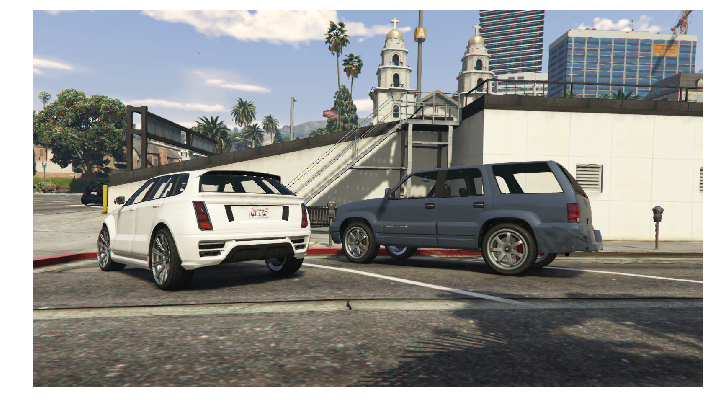

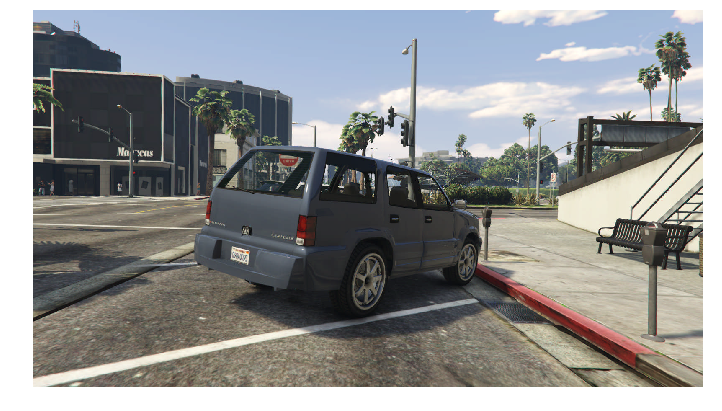

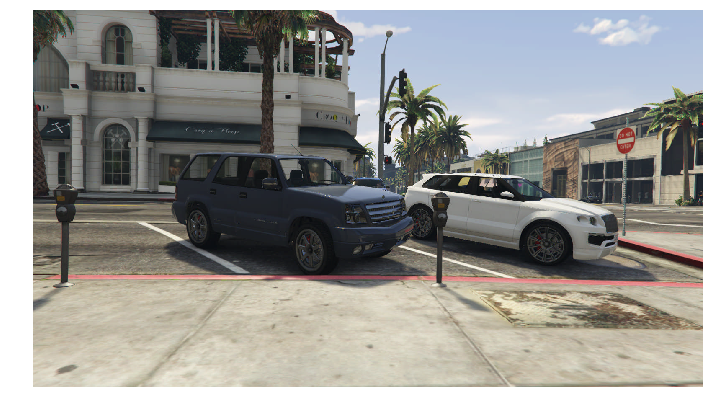

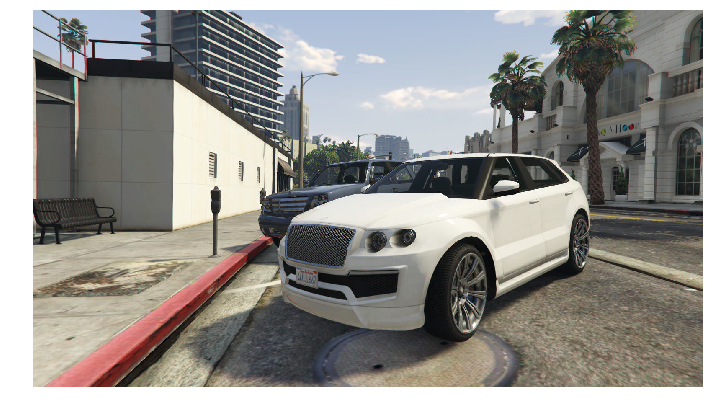

In [3]:
for name in names:
    im = Image.open(os.path.join(visualization.get_in_directory(), name + '.tiff'))
    fig = plt.figure(figsize=(12,12))
    plt.axis('off')
    plt.imshow(im)
    plt.show()

#### showing depth images 

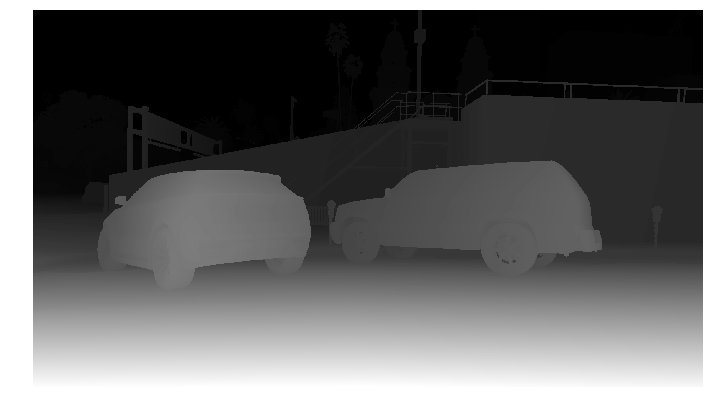

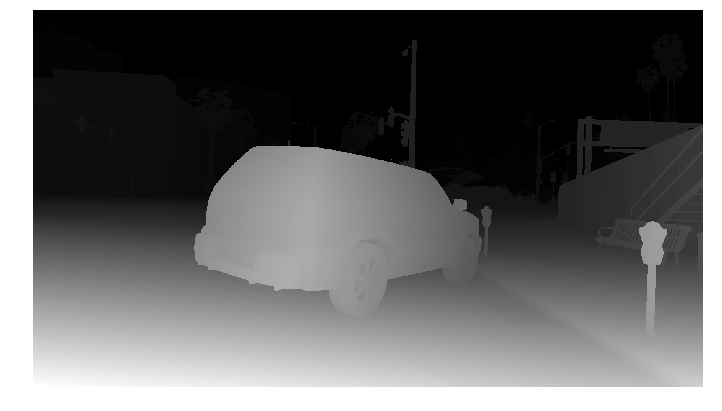

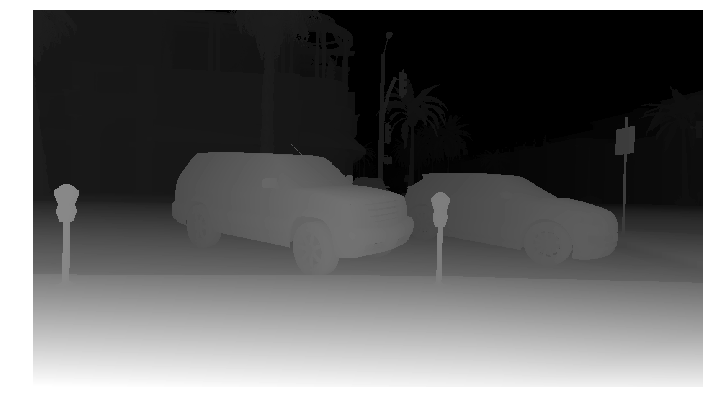

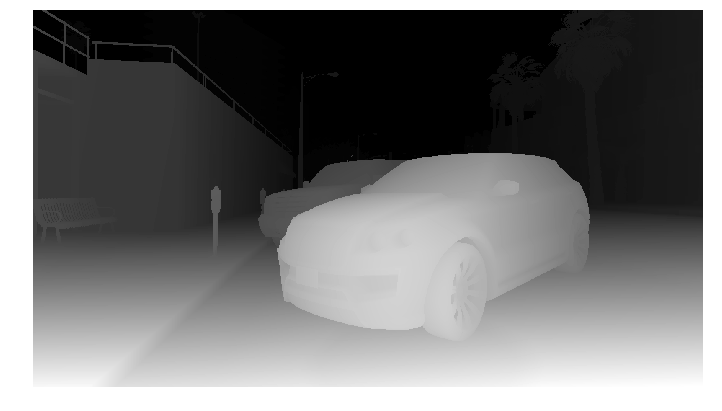

In [4]:
for name in names:
    depth = load_depth(name)
    fig = plt.figure(figsize=(12,12))
    plt.axis('off')
    plt.imshow(depth, cmap='gray')
    plt.show()

In [5]:
def pixel_to_normalized(pixel, size):
    p_y, p_x = pixel
    s_y, s_x = size
    return ((2/s_y)*p_y - 1, (2/s_x)*p_x - 1)

### preparing image and points to project

In [6]:
res = results[3]
name = names[3]
print('keys: '+', '.join(res.keys()))

def prepare_points(res):
    width = res['width']
    height = res['height']
    x_range = range(0, width)
    y_range = range(0, height)
    points = np.transpose([np.tile(y_range, len(x_range)), np.repeat(x_range, len(y_range))])
    return points

points = prepare_points(res)

keys: relative_cam_rot, view_matrix, snapshot_id, timestamp, cam_far_clip, width, cam_near_clip, imagepath, world_matrix, proj_matrix, height


### projecting by projection matrix

In [7]:
# when cutting too far points, I project far clip to depth and then use its value to treshold:
print('transforming far clip')

def points_to_homo(points, res, name):
    width = res['width']
    height = res['height']
    size = (height, width)
    depth = load_depth(name)
    proj_matrix = res['proj_matrix']
    max_depth = res['cam_far_clip']
    #max_depth = 60 # just for testing
    vec = proj_matrix @ np.array([[1], [1], [-max_depth], [1]])
    #print(vec)
    vec /= vec[3]
    treshold = vec[2]

    # vecs = np.zeros((4, points.shape[0]))
    vecs = np.zeros((4, len(np.where(depth[points[:, 0], points[:, 1]] > treshold)[0])))  # this one is used when ommiting 0 depth (point behind the far clip)
    print("vecs.shape")
    print(vecs.shape)
    i = 0
    arr = points
    for y, x in arr:
        if depth[(y, x)] <= treshold:
            continue
        ndc = pixel_to_normalized((y, x), size)
        vec = [ndc[1], -ndc[0], depth[(y, x)], 1]
        vec = np.array(vec)
        vecs[:, i] = vec
        i += 1

    return vecs

def to_view(vecs, res):
    proj_matrix = res['proj_matrix']
    vecs_p = np.linalg.inv(proj_matrix) @ vecs
    vecs_p /= vecs_p[3, :]
    return vecs_p

vecs = points_to_homo(points, res, name)
vecs_p = to_view(vecs, res)

print('projected by inversion')
print(vecs_p)

transforming far clip
vecs.shape
(4, 1230475)
projected by inversion
[[-7.80110538 -7.80123372 -7.80136206 ...,  2.07451384  2.07072732
   2.0669546 ]
 [ 4.01757125  4.0078858   3.99820002 ..., -1.16058339 -1.16105667
  -1.16152822]
 [-9.41036164 -9.41051645 -9.41067126 ..., -2.50558319 -2.50100985
  -2.49645317]
 [ 1.          1.          1.         ...,  1.          1.          1.        ]]


### projecting by view matrix

In [8]:
def to_world(vecs_p, res):
    view_matrix = res['view_matrix']
    vecs_p = np.linalg.inv(view_matrix) @ vecs_p
    vecs_p /= vecs_p[3, :]
    return vecs_p

vecs_p = to_world(vecs_p, res)

In [9]:
def save_csv(vecs_p, name):
    a = np.asarray(vecs_p[0:3, :].T)
    np.savetxt("points-{}.csv".format(name), a, delimiter=",")
    
save_csv(vecs_p, name)

### dumping point clouds for all images in scene

In [10]:
for res, name in zip(results, names):
    points = prepare_points(res)
    vecs = points_to_homo(points, res, name)
    print('image {} points prepared'.format(name))
    vecs_p = to_view(vecs, res)
    vecs_p = to_world(vecs_p, res)
    print('image {} projected'.format(name))
    save_csv(vecs_p, name)
    print('image {} processed'.format(name))

vecs.shape
(4, 1186078)
image 2018-02-22--20-09-16--402 points prepared
image 2018-02-22--20-09-16--402 projected
image 2018-02-22--20-09-16--402 processed
vecs.shape
(4, 1070730)
image 2018-02-22--20-09-17--291 points prepared
image 2018-02-22--20-09-17--291 projected
image 2018-02-22--20-09-17--291 processed
vecs.shape
(4, 1209323)
image 2018-02-22--20-09-18--205 points prepared
image 2018-02-22--20-09-18--205 projected
image 2018-02-22--20-09-18--205 processed
vecs.shape
(4, 1230475)
image 2018-02-22--20-09-19--185 points prepared
image 2018-02-22--20-09-19--185 projected
image 2018-02-22--20-09-19--185 processed
